In [1]:
#import libraries
import numpy as np
from scipy.stats import norm
from matplotlib import pyplot as plt
import math

#tab completion
import rlcompleter
import readline
readline.parse_and_bind("tab: complete")

#for obtaining all possible combinations in C3.
import itertools

#import the Model class from docplex.mp.model
from docplex.mp.model import Model

#plotting
import matplotlib.pyplot as plt

#blocking printing when necessary
from contextlib import contextmanager

In [2]:
class EuropeanCallOption:
    def __init__(self, spot_price, strike, risk_free_rate, volatility, maturity):
        self.S = spot_price
        self.K = strike
        self.r = risk_free_rate
        self.sigma = volatility
        self.T = maturity

    def calculate_price(self):
        d1 = (np.log(self.S / self.K) + (self.r + self.sigma ** 2 / 2) * self.T) / (self.sigma * np.sqrt(self.T))
        d2 = d1 - self.sigma * np.sqrt(self.T)
        price = (self.S * norm.cdf(d1)) - (self.K * np.exp(-self.r * self.T) * norm.cdf(d2))
        return price

In [3]:
class WeightsVolatilitiesInitializer:
    @staticmethod
    def initialize(n):
        if n == 3:
            w = np.array([0.3, 0.35, 0.35])
            vols = np.array([1, 1.6, 2.0])
        elif n == 4:
            w = np.array([0.1, 0.2, 0.3, 0.4])
            vols = np.array([0.3, 0.3, 1.8, 1.2])
        elif n == 5:
            w = np.ones(n) / n
            vols = np.array([0.3, 0.4, 0.8, 1.8, 1.9])
        elif n == 6:
            w = np.array([0.1, 0.1, 0.1, 0.1, 0.3, 0.3])
            vols = np.array([0.3, 0.5, 1.3, 1.5, 1.9, 2.1])
        elif n == 8:
            w = np.array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.3])
            vols = np.array([0.1, 0.2, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0])
        elif n == 10:
            w = np.ones(n) / n
            vols = np.array([0.02, 0.05, 0.1, 0.13, 0.15, 0.2, 0.23, 0.25, 0.29, 0.35])
        else:
            w = np.ones(n) / n
            vols = np.ones(n)
        return w, vols

In [4]:
class OptionInitializer:
    def __init__(self, n, m, spot_price, risk_free_rate, maturity, strike):
        self.n = n
        self.m = m
        self.S = spot_price
        self.r = risk_free_rate
        self.T = maturity
        self.K = strike

    def initialize(self):
        w, vols = WeightsVolatilitiesInitializer.initialize(self.n)
        c = [[] for _ in range(self.n)]
        K = np.tile(np.arange(100, 100 + self.m), (self.n, 1)).astype(float)
        for i in range(self.n):
            for Kij in K[i]:
                option = EuropeanCallOption(self.S, Kij, self.r, vols[i], self.T)
                c[i].append(option.calculate_price())
        return K, np.array(c), w

$$\mathcal{C}_0=\mathcal{C}_1\cup \mathcal{C}_2$$

$$\mathcal{C}_1=\left \{s\in \mathbb{R}^n_+ \mid \forall i, s_i=0 \text{ or } K_{ij} \text{ for some }j\right\}$$

$$\mathcal{C}_2=\bigcup\limits_{k=1}^n\mathfrak{B}_k$$

$$\mathfrak{B}_k=\left\{s\in \mathbb{R}^n_+ \mid \forall i \not= k, s_i=0 \text{ or } K_{ij} \text{ for some }j, \ s_k=w_k^{-1}\Big( K- \sum\limits_{i=1,i\not=k}^n w_is_i \Big)\ge 0\right\}$$
    
$$ \mathcal{C}_3=\left \{(s_1,\dots,s_n) \mid \text{ for some } i, s_i=K_{i0} \text{ or } K_{im} \text{ and for some }p, s_j=K_{jp} \ \forall \ j\not=i\right\}$$

In [5]:
class ConstraintSet:
    def __init__(self, n, m, spot_price, risk_free_rate, maturity, strike):
        self.initializer = OptionInitializer(n, m, spot_price, risk_free_rate, maturity, strike)

    def C1(self):
        K, _, _ = self.initializer.initialize()
        return np.array([i for i in itertools.product(np.insert(K[0, :], 0, 0), repeat=self.initializer.n)])

    def Bk(self, k, strike):
        K, _, w = self.initializer.initialize()
        Bk_old = [i for i in itertools.product(np.insert(K[0, :], 0, 0), repeat=self.initializer.n - 1)]
        Bk_new = [np.insert(s, k, (strike - np.sum(np.delete(w, k) * np.array(s))) / w[k]) for s in Bk_old if (strike - np.sum(np.delete(w, k) * np.array(s))) / w[k] >= 0]
        return np.array(Bk_new)

    def C2(self):
        K, _, _ = self.initializer.initialize()
        C2 = [self.Bk(k, self.initializer.K) for k in range(self.initializer.n)]
        return np.array(C2)

    def C0(self):
        C0 = [self.C1()]
        C0.extend(self.C2())
        return np.array(C0)

    def C3(self):
        K, _, _ = self.initializer.initialize()
        Set = [i for i in itertools.product([0, K[0, -1]], repeat=self.initializer.n - 1)]
        C3 = [np.insert(s, 0, 0) for s in Set]
        for s in Set:
            for i in range(self.initializer.n):
                for j in range(1, self.initializer.m - 1):
                    C3.append(np.insert(s, i, K[i, j]))
        C3.append(np.insert(Set[0], 0, K[0, -1]))
        return np.array(C3)

In [6]:
class LinearProgrammingProblem:
    def __init__(self, n, m, spot_price, risk_free_rate, maturity, strike):
        self.initializer = OptionInitializer(n, m, spot_price, risk_free_rate, maturity, strike)
        self.strike = strike

    def solve(self, C_big):
        K, c, w = self.initializer.initialize()

        if C_big.ndim == 2:
            C_big = np.array([C_big])

        mdl = Model(name='Linear_Program')

        z = mdl.continuous_var(name='z', lb=-math.inf)
        y = mdl.continuous_var_matrix(range(self.initializer.n), range(self.initializer.m), name='y', lb=-math.inf)

        for C_small in C_big:
            for s in C_small:
                sum_value = mdl.sum(max(s[i] - K[i, j], 0) * y[i, j] for i in range(self.initializer.n) for j in range(self.initializer.m))
                mdl.add_constraint(z + sum_value <= max(np.inner(w, s) - self.strike, 0))

        mdl.add_constraints(mdl.sum(y[i, j] for j in range(self.initializer.m)) <= w[i] for i in range(self.initializer.n))

        sum_prod = mdl.sum(c[i, j] * y[i, j] for i in range(self.initializer.n) for j in range(self.initializer.m))
        mdl.maximize(z + sum_prod)

        sol = mdl.solve(url=None, key=None)

        print(sol)
        print("solve status =", mdl.get_solve_status())

        y_matrix = np.array([[sol.get_value(y[i, j]) for j in range(self.initializer.m)] for i in range(self.initializer.n)])

        return sol.get_value(z), y_matrix, sol.get_objective_value()

In [7]:
class Lattice:
    def __init__(self, n, m, spot_price, risk_free_rate, maturity, strike):
        self.initializer = OptionInitializer(n, m, spot_price, risk_free_rate, maturity, strike)

    def compute(self):
        K, _, w = self.initializer.initialize()
        K_tr = K.transpose()

        boolean = np.all((w * Kij).astype(int) == w * Kij for Kij in K_tr)
        arr = np.concatenate([w * Kij for Kij in K_tr])

        gcd = np.gcd.reduce(arr.astype(np.int64)) if boolean else 1
        gcd = max(gcd, 1)
        
        M = np.sum(w * K_tr[-1])
        return range(0, int(M) + 1, gcd)

In [8]:
class SeparationAlgorithm:
    def __init__(self, n, m, spot_price, risk_free_rate, maturity, strike):
        self.initializer = OptionInitializer(n, m, spot_price, risk_free_rate, maturity, strike)
        self.strike = strike

    def separation_problem(self, J, K, z, y):
        f   = [[]]
        g   = [[]]
        for i in range(0,n-1):
            f.append([])
            g.append([])

        for i in range(0,len(J)):
                f[0].append(low)
                g[0].append(-1)

        for x in J:
            # Comparison for K10 = 0.
            if(x == 0):
                f[0][J.index(x)] =  z
                g[0][J.index(x)] = -1
            # Comparison for the rest K1j j in {1,...,m}.
            for h in range(0,m):
                if(x == w[0]*K[0,h]):
                    f[0][J.index(x)] = f0(x,h,z,y)
                    g[0][J.index(x)] = h

        ############
        # STEP (2) #
        ############
        for i in range(1,n):
            # Initialize.
            for x in J:
                f[i].append(low)
                g[i].append(-1)
            for x in J:
                arr_2_f = []
                arr_2_g = []
                # Comparison for Ki0 = 0 i in {1,...,n}.
                if(x < len(J)-1):
                    if(f[i-1][x] > low):
                        arr_2_f.append(f[i-1][x])

                        arr_2_g.append(-1)
                # Comparison for the rest Kij j in {1,..,m}.
                for h in range(0,m):
                    if(((x - w[i]*K[i,h]).is_integer()) and (x - w[i]*K[i,h] >= 0) and\
                        (x - w[i]*K[i,h] < len(J)-1)):
                        if(f[i-1][int(x - w[i]*K[i,h])] > low):

                            arr_2_f.append(f[i-1][int(x - w[i]*K[i,h])]+\
                            np.sum(np.maximum(K[i,h]-K[i,:],0)*y[i,:]))

                            arr_2_g.append(h)

                if(len(arr_2_f)>0):
                    f[i][J.index(x)] = np.amax(arr_2_f)
                    g[i][J.index(x)] = arr_2_g[np.argmax(arr_2_f)]

        ############
        # STEP (3) #
        ############
        f     = np.array(f)
        g     = np.array(g)

        # Array containing violated constraints for C1 and each Bk, k in {1,...,n}.
        new_constraints = []

        arr_3 = []
        for x in J:
            fn = f[n-1,J.index(x)]
            arr_3.append(fn - max(x-strike,0))
        index = np.argmax(arr_3)
        # Here J(index) represents x* in the notation.
        fn_xstar = f[n-1][index]
        if(fn_xstar > max(J[index]-strike,0)):
            # IN CASE OF ERROR ENABLE THE CODE BELLOW TO DISPLAY PROCEDURE.
            print("fn_xstar,(x*-K)^+, index:", fn_xstar, max(J[index]-strike,0), index)
            print("array 3 = ", arr_3)

            violations_1 = []
            iterator_1   = 0
            print('VIOLATED OVER SET C1')
            for i in g[:, index]:
                    if(i>=0):
                        violations_1.append(K[iterator_1,i])
                    else:
                        violations_1.append(0)
                    iterator_1 +=1

            # IN CASE OF ERROR ENABLE THE CODE BELLOW TO DISPLAY STORED VALUES.            
            print(f)
            print("***")
            print(g)
            print('===')

            violations_1 = np.array(violations_1)
            new_constraints.append(violations_1)

            # IN CASE OF ERROR ENABLE THE CODE BELLOW TO DISPLAY INDICES.
            #print("Violated with s indexed as ind(si) (if ind(si)=j with si=Kij).")
            #print("ind(si)= ",g[:, J[index]]) 

        ############
        # STEP (4) #
        ############
        f_new = [[]]
        g_new = [[]]
        # There are #n different I sets according to step 4.
        for i in range(1,n):
            f_new.append([])
            g_new.append([])
        # Each I set contains #n-1 elements.
        for j in range(0,n-1):
            for i in range(0,n):
                f_new[i].append([])
                g_new[i].append([])

        # Initialize:
        for x in J:
            if(x<=strike):
                for i in range(0,n):
                    for j in range(0,n-1):
                        f_new[i][j].append(low)
                        g_new[i][j].append(-1)


        for i in range(0,n):   
            for j in range(0,n-1):
                # Do steps (1) & (2) for i in I and x<=K.
                for x in J:
                    if(x<=strike):
                        if(j==0):
                            # B1 set exception.
                            if(i==0):
                                # Comparison for K10 = 0.
                                if(x == 0):
                                    f_new[i][0][J.index(x)] =  z
                                    g_new[i][0][J.index(x)] = -1
                                # Comparison for the rest K1j j in {1,...,m}.
                                for h in range(0,m):
                                    if(x == w[1]*K[1][h]):
                                        f_new[i][0][J.index(x)] = f0(x,h,z,y)
                                        g_new[i][0][J.index(x)] = h
                            else:
                                # Comparison for K10 = 0.
                                if(x == 0):
                                    f_new[i][0][J.index(x)] =  z
                                    g_new[i][0][J.index(x)] = -1
                                # Comparison for the rest K1j j in {1,...,m}.
                                for h in range(0,m):
                                    if(x == w[0]*K[0][h]):
                                        f_new[i][0][J.index(x)] = f0(x,h,z,y)
                                        g_new[i][0][J.index(x)] = h
                        else:
                            arr_4_f = []
                            arr_4_g = []
                            # B1 set exception.
                            if(i==0):
                                # Comparison for Ki0 = 0 i in {1,...,n}.
                                if(x < len(J)-1):
                                    if(f_new[i][j-1][x] > low):
                                        arr_4_f.append(f_new[i][j-1][x])

                                        arr_4_g.append(-1)

                                for u in range(2,n):
                                    # Comparison for the rest Kij j in {1,..,m}.
                                    for h in range(0,m):
                                        if(((x - w[u]*K[u,h]).is_integer()) and (x - w[u]*K[u,h] >= 0) and\
                                            (x - w[u]*K[u,h] < len(J)-1)):
                                            if(f_new[i][j-1][int(x - w[u]*K[u,h])] > low):

                                                arr_4_f.append(f_new[i][j-1][int(x - w[u]*K[u,h])] +\
                                                np.sum(np.maximum(K[u,h]-K[u,:],np.zeros(m))*y[u,:]))

                                                arr_4_g.append(h)
                            else:
                                # Comparison for Ki0 = 0 i in {1,...,n}.
                                if(x < len(J)-1):
                                    if(f_new[i][j-1][x] > low):
                                        arr_4_f.append(f_new[i][j-1][x])

                                        arr_4_g.append(-1)

                                for u in np.delete(range(1,n),i-1,axis=0):
                                    # Comparison for the rest Kij j in {1,..,m}.
                                    for h in range(0,m):
                                        if(((x - w[u]*K[u,h]).is_integer()) and (x - w[u]*K[u,h] >= 0) and\
                                            (x - w[u]*K[u,h] < len(J)-1)):
                                            if(f_new[i][j-1][int(x - w[u]*K[u,h])] > low):

                                                arr_4_f.append(f_new[i][j-1][int(x - w[u]*K[u,h])] +\
                                                np.sum(np.maximum(K[u,h]-K[u,:],np.zeros(m))*y[u,:]))

                                                arr_4_g.append(h)

                            if(len(arr_4_f)>0):
                                f_new[i][j][J.index(x)] = np.amax(arr_4_f)
                                g_new[i][j][J.index(x)] = arr_4_g[np.argmax(arr_4_f)]


            f_new = np.array(f_new)
            g_new = np.array(g_new)


            arr_4 = []
            for x in J:
                if(x<=strike):
                    arr_4.append(np.amax(f_new[i,:,J.index(x)])+np.sum(np.maximum((strike-x)/w[i]-K[i,:],np.zeros(m))*y[i,:]))

            index_new = np.argmax(arr_4)

            # IN CASE OF ERROR ENABLE THE CODE BELLOW TO DISPLAY PROCEDURE.
            print("Index of argmax:", index_new)
            print("iteration number=", i,"array 4 = ", arr_4)
            if(arr_4[index_new]>0):
                violations_2 = []
                iterator_2   = 0
                print("VIOLATED OVER SET C2")
                for j in g_new[i,:, index_new]:
                    if(j>=0):
                        violations_2.append(float(K[iterator_2,j]))
                    else:
                        violations_2.append(float(0))
                    iterator_2 +=1
                if(i == len(violations_2)+1):
                    violations_2 = violations_2.append(               (strike-J[index_new])/w[i])

                else:
                    violations_2 = np.insert(          violations_2,i,(strike-J[index_new])/w[i])
                print(violations_2)
                new_constraints.append(violations_2)
                
            # IN CASE OF ERROR ENABLE THE CODE BELLOW TO DISPLAY INDICES.
            #print("Violated with s indexed as ind(si) (if ind(si)=j with si=Kij).")
            #print("ind(si)= ", g_new[i, :, index_new])
            #print("sp     = ",(strike-J[index_new])/w[i])
            
    # IN CASE OF ERROR ENABLE THE CODE BELLOW TO DISPLAY STORED VALUES.            
    #     print(f_new)
    #     print("***")
    #     print(g_new)
    #     print('===')
    #     print("f length:", len(f[0]))
    #     print("f_new length:", len(f_new))

        new_constraints = np.array(new_constraints)

        print( new_constraints)
        return new_constraints

In [9]:
class LowerBoundAlgorithm:
    def __init__(self, n, m, spot_price, risk_free_rate, maturity, strike):
        self.lp_problem = LinearProgrammingProblem(n, m, spot_price, risk_free_rate, maturity, strike)
        self.separation_algorithm = SeparationAlgorithm(n, m, spot_price, risk_free_rate, maturity, strike)

    def calculate(self, C, J, K):
        statement = True
        lb_temp = 0
        lb      = 1
        while(statement == True and lb_temp != lb):
            lb_temp  = lb
            z, y, lb = self.lp_problem.solve(C)
            if(math.isclose(lb, lb_temp, abs_tol=1e-4)):
                return lb
            con = self.separation_algorithm.separation_problem(J, K, z, y)
            if(len(con) == 0):
                return lb
            if(con.ndim==1):
                C_new = np.append(C,[con],axis=0)
            else:
                C_new = np.append(C,con,axis=0)
            C = C_new
            statement = (con.size != 0)
        return lb

In [10]:
# TODO REFACTOR

####################################################################################
#                        Defining functions fi for i=0                             #
####################################################################################
def f0(x,h,z,y):
    return z + np.sum(np.maximum(K[0,h]-K[0,:],np.zeros(m))*y[0,:])

In [11]:
################################################################################### 
# Initializing inputs as described in Section 3: "Numerical Results" of paper.    #
# In particular we take:                                                          #
# n = #  assets                                                                   # 
# m = #  European call options                                                    #
###################################################################################
n = 3
m = 2

# Spot price
S = 100
# Strike price
strike = 90
# Maturity, interest rate
T = 1
r = 0

#################################################################################
#                     INPUT OF SEPARATION ALGORITHM                             #
#################################################################################

# Initialize the classes
option_initializer = OptionInitializer(n, m, S, r, T, strike)
constraint_set = ConstraintSet(n, m, S, r, T, strike)
lattice = Lattice(n, m, S, r, T, strike)
lp_problem = LinearProgrammingProblem(n, m, S, r, T, strike)

# Generate initial constraints
C0 = constraint_set.C0()

# Solve the LP problem
z, y, _ = lp_problem.solve(C0)

# Initialize options and weights
K, _, w = option_initializer.initialize()

# Generate lattice J
J = lattice.compute()

low = -math.inf

separation_algorithm = SeparationAlgorithm(n, m, S, r, T, strike)
new_C = separation_algorithm.separation_problem(J, K, z, y)

# Example placeholder for calling the LowerBoundAlgorithm
lower_bound_algorithm = LowerBoundAlgorithm(n, m, S, r, T, strike)
lb = lower_bound_algorithm.calculate(C0, J, K)

print(f"Lower Bound: {lb}")

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:23: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


solution for: Linear_Program
objective: 23.7688
y_1_0=-54.650
y_1_1=55.000
y_2_0=-54.650
y_2_1=55.000

solve status = JobSolveStatus.OPTIMAL_SOLUTION
Index of argmax: 0
iteration number= 0 array 4 =  [0.0, -inf, -inf, -inf, -inf, -inf, -inf, 0.0, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf]
Index of argmax: 0
iteration number= 1 array 4 =  [0.0, -inf, -inf, -inf, -inf, -inf, -30.0, -35.000000000000455, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf]
Index of argmax: 0
iteration number= 2 array 4 =  [0.0, -inf, -inf, -inf, -inf, -inf, -30.0, -35.000000000000455, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf]
[]
solution for: Linear_Program
objective: 23.7688
y_1_0=-54.650
y_1_1=55.000
y_2_0=-54.650
y_2_1=55.000

solve status = JobSolveStatus.OPTIMAL_SOLUTION
Index of argmax: 0
iteration number= 0 array 4 =  [0.0, -inf, -inf, -inf, -inf, -inf, -inf, 0.0, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf]
Index of ar

In [12]:
################################################################################### 
#                      BLOCK PRINTING WHEN NECESSARY                              #
###################################################################################
@contextmanager
def blockPrint():
    import sys
    old_stdout = sys.stdout
    sys.stdout = None
    try:
        yield
    finally:
        sys.stdout = old_stdout

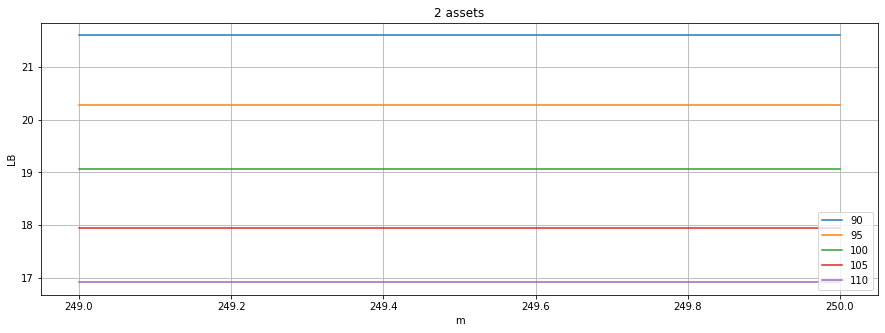

In [13]:
#################################################################################
#                               TESTING FOR n=2                                 #
#################################################################################

#spot price.
S = 100
#strike prices.
strikes = range(90,111,5)
#maturity, interest rate.
T = 1; r = 0

low  = -math.inf

# Create two subplots and unpack the output array immediately
fig, ax1 = plt.subplots(1, 1,figsize=(15,5))


n_a    = 2
n      = n_a
m_a    = np.array(range(249, 251, 1))
m_a # MaxValue=250 for n=2

# Block in-function printing commands
with blockPrint():
    for strike in strikes:
        lb_a = []
        for m in m_a:   
            option_initializer = OptionInitializer(n, m, S, r, T, strike)
            constraint_set = ConstraintSet(n, m, S, r, T, strike)
            lattice = Lattice(n, m, S, r, T, strike)
            lp_problem = LinearProgrammingProblem(n, m, S, r, T, strike)

            # Generate initial constraints
            C3 = constraint_set.C3()

            # Solve the LP problem
            z, y, _ = lp_problem.solve(C3)

            # Initialize options and weights
            K, _, w = option_initializer.initialize()

            # Generate lattice J
            J = lattice.compute()

            separation_algorithm = SeparationAlgorithm(n, m, S, r, T, strike)
            new_C = separation_algorithm.separation_problem(J, K, z, y)

            # Example placeholder for calling the LowerBoundAlgorithm
            lower_bound_algorithm = LowerBoundAlgorithm(n, m, S, r, T, strike)
            lb = lower_bound_algorithm.calculate(C3, J, K)

            lb_a.append(lb)

        ax1.plot(m_a, lb_a, label=strike)

    ax1.set_title('2 assets')
    ax1.set_xlabel('m')
    ax1.set_ylabel('LB')
    ax1.legend(loc = 4)
    ax1.grid()

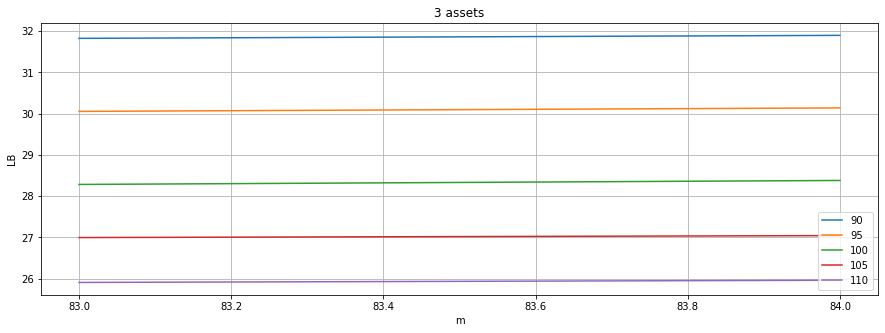

In [14]:
#################################################################################
#                             TESTING FOR n=3                                   #
#################################################################################

#spot price.
S = 100
#strike prices.
strikes = range(90,111,5)
#maturity, interest rate.
T = 1; r = 0

low  = -math.inf

# Create two subplots and unpack the output array immediately
fig, ax = plt.subplots(1, 1,figsize=(15,5))


# Block in-function printing commands
with blockPrint():
    n_b    = 3
    n      = n_b
    m_b    = np.array(range(83, 85, 1))

    m_b # MaxValue=84 for n=3  
    
    for strike in strikes:
        lb_b = []
        for m in m_b:
            option_initializer = OptionInitializer(n, m, S, r, T, strike)
            constraint_set = ConstraintSet(n, m, S, r, T, strike)
            lattice = Lattice(n, m, S, r, T, strike)
            lp_problem = LinearProgrammingProblem(n, m, S, r, T, strike)

            # Generate initial constraints
            C3 = constraint_set.C3()

            # Solve the LP problem
            z, y, _ = lp_problem.solve(C3)

            # Initialize options and weights
            K, _, w = option_initializer.initialize()

            # Generate lattice J
            J = lattice.compute()

            separation_algorithm = SeparationAlgorithm(n, m, S, r, T, strike)
            new_C = separation_algorithm.separation_problem(J, K, z, y)

            # Example placeholder for calling the LowerBoundAlgorithm
            lower_bound_algorithm = LowerBoundAlgorithm(n, m, S, r, T, strike)
            lb = lower_bound_algorithm.calculate(C3, J, K)
            lb_b.append(lb);

        ax.plot(m_b,lb_b,label=strike)
    ax.set_title('3 assets')
    ax.set_xlabel('m')
    ax.set_ylabel('LB')
    ax.legend(loc = 4)
    ax.grid()

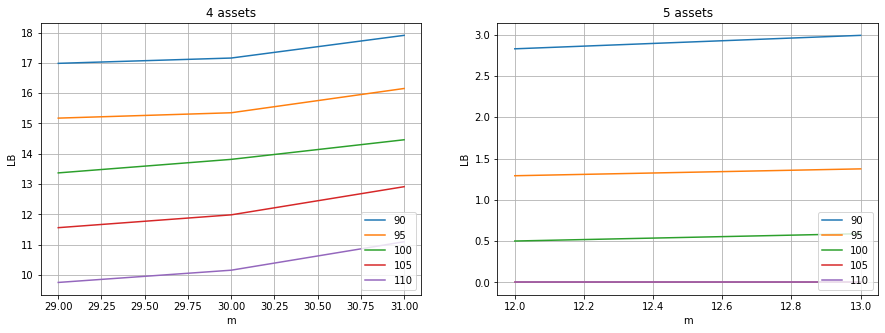

In [15]:
#################################################################################
#                         TESTING FOR n=4 and n=5                               #
#################################################################################

#spot price.
S = 100
#strike prices.
strikes = range(90,111,5)
#maturity, interest rate.
T = 1; r = 0

low  = -math.inf

# Create two subplots and unpack the output array immediately
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5))


# Block in-function printing commands
with blockPrint():
    n_a    = 4
    n      = n_a
    m_a    = np.array(range(29, 32, 1))
    m_a # MaxValue=31 for n=4
    
    for strike in strikes:
        lb_a = []
        for m in m_a:
            option_initializer = OptionInitializer(n, m, S, r, T, strike)
            constraint_set = ConstraintSet(n, m, S, r, T, strike)
            lattice = Lattice(n, m, S, r, T, strike)
            lp_problem = LinearProgrammingProblem(n, m, S, r, T, strike)

            # Generate initial constraints
            C3 = constraint_set.C3()

            # Solve the LP problem
            z, y, _ = lp_problem.solve(C3)

            # Initialize options and weights
            K, _, w = option_initializer.initialize()

            # Generate lattice J
            J = lattice.compute()

            separation_algorithm = SeparationAlgorithm(n, m, S, r, T, strike)
            new_C = separation_algorithm.separation_problem(J, K, z, y)

            # Example placeholder for calling the LowerBoundAlgorithm
            lower_bound_algorithm = LowerBoundAlgorithm(n, m, S, r, T, strike)
            lb = lower_bound_algorithm.calculate(C3, J, K)
            lb_a.append(lb);

        ax1.plot(m_a,lb_a,label=strike)
    ax1.set_title('4 assets')
    ax1.set_xlabel('m')
    ax1.set_ylabel('LB')
    ax1.legend(loc = 4)
    ax1.grid()
    
    n_b    = 5
    n      = n_b
    m_b    = np.array(range(12, 14, 1))

    m_b # MaxValue=13 for n=5
    
    for strike in strikes:
        lb_b = []
        for m in m_b:
            option_initializer = OptionInitializer(n, m, S, r, T, strike)
            constraint_set = ConstraintSet(n, m, S, r, T, strike)
            lattice = Lattice(n, m, S, r, T, strike)
            lp_problem = LinearProgrammingProblem(n, m, S, r, T, strike)

            # Generate initial constraints
            C3 = constraint_set.C3()

            # Solve the LP problem
            z, y, _ = lp_problem.solve(C3)

            # Initialize options and weights
            K, _, w = option_initializer.initialize()

            # Generate lattice J
            J = lattice.compute()

            separation_algorithm = SeparationAlgorithm(n, m, S, r, T, strike)
            new_C = separation_algorithm.separation_problem(J, K, z, y)

            # Example placeholder for calling the LowerBoundAlgorithm
            lower_bound_algorithm = LowerBoundAlgorithm(n, m, S, r, T, strike)
            lb = lower_bound_algorithm.calculate(C3, J, K)
            lb_b.append(lb);

        ax2.plot(m_b,lb_b,label=strike)
    ax2.set_title('5 assets')
    ax2.set_xlabel('m')
    ax2.set_ylabel('LB')
    ax2.legend(loc = 4)
    ax2.grid()